C:\Users\UAI5FE\OneDrive - Bosch Group\00_DHBW\git\T3M40507_Maschinelles_Lernen_und_Computational Intelligence
    Groesse  Gewicht Geschlecht  Alter Normalgewichtig  Boolean
0       170       67          m     26              ja        1
1       163       89          w     53            nein        0
2       141       58          w     43            nein        0
3       158       65          w     48            nein        0
4       153       55          w     28              ja        1
5       187      104          w     86            nein        0
6       145       59          w     23            nein        0
7       181       80          m     84              ja        1
8       169       86          w     71            nein        0
9       164       78          w     29            nein        0
10      169       76          w     55            nein        0
11      176       78          m     68              ja        1
12      196       97          m     28            nein   

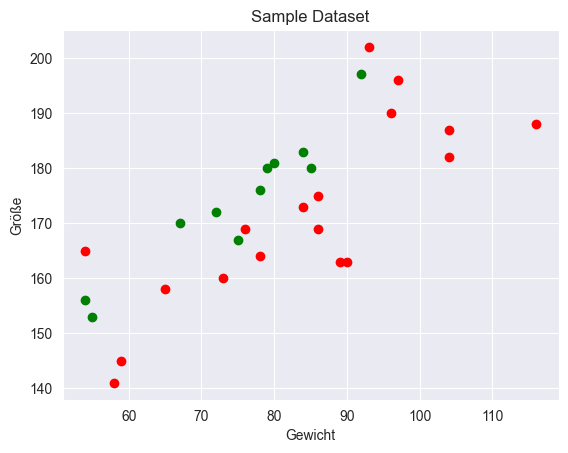

In [42]:
# Introduction to Backpropagation Neural Networks

# Prof. Dr. Dirk Reichardt - DHBW

# important stuff to import ...

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

from math import exp
from random import random


# Read Sample Training Data 

trainingData = "bmi_lern_2.csv"

print(os.getcwd() )

##os.chdir('/Users/dirkreichardt/Downloads/')  # put your own path here ...

data = pd.read_csv(trainingData, sep=";")  # start with the well known mini dataset for perceptron

print(data)

# and visualize it ...

pos = (data["Boolean"] == 1)
positives = data[pos]
positives = np.array(positives)

neg = (data["Boolean"] == 0)
negatives = data[neg]
negatives = np.array(negatives)

plt.scatter(positives[:,1],positives[:,0], color = 'green')
plt.scatter(negatives[:,1],negatives[:,0], color = 'red')

plt.title('Sample Dataset')
plt.xlabel('Gewicht')
plt.ylabel('Größe')

plt.show()


In [43]:
# defining a feed forward network as a class

class feedForwardNetwork():

    def __init__ (self):
    
        self.MAX_INPUT_LAYER_SIZE=20         # old array limitations inherited from a C/C++ program
        self.MAX_HIDDEN_LAYER_SIZE=40
        self.MAX_OUTPUT_LAYER_SIZE=20

        self.INPUT_TO_HIDDEN=0
        self.HIDDEN_TO_OUTPUT=1  

        self.DEFAULT_EPSILON=1
        self.DEFAULT_LEARNING_RATE=0.01    
    
        self.inNeurons = 0
        self.hiddenNeurons = 0
        self.outNeurons = 0
    
        self.InputLayer = np.zeros(self.MAX_INPUT_LAYER_SIZE)
        self.HiddenLayer = np.zeros(self.MAX_HIDDEN_LAYER_SIZE)
        self.OutputLayer = np.zeros(self.MAX_OUTPUT_LAYER_SIZE)
        
        self.weightsToHidden = np.zeros((self.MAX_INPUT_LAYER_SIZE+1,self.MAX_HIDDEN_LAYER_SIZE))
        self.weightsToOutput = np.zeros((self.MAX_HIDDEN_LAYER_SIZE+1,self.MAX_OUTPUT_LAYER_SIZE))
        
    
    # every application should first configure the neural net
    
    def configure(self,inLayer, hiddenLayer, outLayer):
        if ((inLayer > 0) and (inLayer < self.MAX_INPUT_LAYER_SIZE)):
            self.inNeurons = inLayer
        else:
            self.inNeurons = 1
            
        if ((hiddenLayer > 0) and (hiddenLayer < self.MAX_HIDDEN_LAYER_SIZE)):
            self.hiddenNeurons = hiddenLayer
        else:
            self.hiddenNeurons = 1
            
        if ((outLayer > 0) and (outLayer < self.MAX_OUTPUT_LAYER_SIZE)):
            self.outNeurons = outLayer
        else:
            self.outNeurons = 1

        self.epsilon = self.DEFAULT_EPSILON
        self.learningRate = self.DEFAULT_LEARNING_RATE

    def init(self):    # initialize weights
              
        # all neuron activations set to 0

        for i in range(0,self.MAX_INPUT_LAYER_SIZE):
            self.InputLayer[i] = 0.0

        self.InputLayer[self.inNeurons] = 1  # threshold activation (common trick)

        for i in range(0,self.MAX_HIDDEN_LAYER_SIZE):
            self.HiddenLayer[i] = 0.0

        self.HiddenLayer[self.hiddenNeurons] = 1  # threshold activation (common trick)
        
        for i in range(0,self.MAX_OUTPUT_LAYER_SIZE):
            self.OutputLayer[i] = 0.0
          
        # all weights are set to 0
      
        for i in range(0,self.MAX_INPUT_LAYER_SIZE+1):
            for j in range(0,self.MAX_HIDDEN_LAYER_SIZE):
                self.weightsToHidden[i][j] = 0.0

        for i in range(0,self.MAX_HIDDEN_LAYER_SIZE+1):
            for j in range(0,self.MAX_OUTPUT_LAYER_SIZE):
                self.weightsToOutput[i][j] = 0.0

        # the weights of the configured net (node subset)
        # are set to a random number between -0.5 and 0.5

        for i in range(0,self.MAX_INPUT_LAYER_SIZE+1):
            for j in range(0,self.MAX_HIDDEN_LAYER_SIZE):
                self.weightsToHidden[i][j] = ((random()*100-50)/100)
              

        for i in range(0,self.MAX_HIDDEN_LAYER_SIZE+1):
            for j in range(0,self.MAX_OUTPUT_LAYER_SIZE):
                self.weightsToOutput[i][j] = ((random()*100-50)/100)

    @staticmethod
    def t(x):   # sigmoid function (activation)
        return (1/(1 + exp(-x)))

    def setInput(self,x,value):
        if ((x >= 0) and (x < self.inNeurons) and (value >= 0) and (value <= 1)):
            self.InputLayer[x] = value

    def setOutput(self,x,value):
        if ((x >= 0) and (x < self.outNeurons) and (value >= 0) and (value <= 1)):
            self.OutputLayer[x] = value

    def getInput(self,x):
        ret = -1
        if ((x >= 0) and (x < self.inNeurons)):
            ret = self.InputLayer[x]
        return ret

    def getOutput(self,x):
        ret = -1
        if ((x >= 0) and (x < self.outNeurons)):
            ret = self.OutputLayer[x]
        return ret

    def getHidden(self,x):
        ret = -1
        if ((x >= 0) and (x < self.hiddenNeurons)):
            ret = self.HiddenLayer[x]
        return ret

    def getWeight(self,layer,x,y):
        ret = -1
        if (layer == self.INPUT_TO_HIDDEN): # from input to hidden       
            if ((x >= 0) and (x < self.inNeurons+1) and   #includes threshold
                (y >= 0) and (y < self.hiddenNeurons)):
                    ret = self.weightsToHidden[x][y]
                
        if (layer == self.HIDDEN_TO_OUTPUT): # from hidden layer to output
            if ((x >= 0) and (x < self.hiddenNeurons+1) and   #includes threshold
                (y >= 0) and (y < self.outNeurons)):
                    ret = self.weightsToOutput[x][y]
        return ret
    
    def apply(self):
        # propagate activation through the net
        # compute hidden layer activation

        self.InputLayer[self.inNeurons]= 1  # for threshold computation

        for j in range(0,self.hiddenNeurons):
            net = 0 # netto input of a neuron
                
            for i in range(0,self.inNeurons+1):          
                net += self.weightsToHidden[i][j]*self.InputLayer[i]
                self.HiddenLayer[j] = self.t(net)  # using transfer function (sigmoid)
        

        for j in range(0,self.outNeurons):
            net = 0 # netto input of a neuron

            for i in range(0,self.hiddenNeurons+1):
                net += self.weightsToOutput[i][j]*self.HiddenLayer[i]
                self.OutputLayer[j] = self.t(net)  # using transfer function (sigmoid)
                
                
    def backpropagate(self,t):
        
        # neural network learning step

        deltaH = np.zeros(self.hiddenNeurons+1)
        
        e = self.energy(t,self.OutputLayer,self.outNeurons)

        if (self.epsilon < e):
        
            # backpropagation
            # update weights to output layer
            # Formula :  delta_wij = learning_rate dj hiddenlayer_i
            #                   dj = (tj-yj)yj(1-yj)
                      
            for j in range(0,self.outNeurons):
                y = self.OutputLayer[j]
                delta = (t[j]-y)*y*(1-y)

                for i in range(0,self.hiddenNeurons+1):
                    deltaH[i] += delta * self.weightsToOutput[i][j]
                    self.weightsToOutput[i][j] += self.learningRate * delta * self.HiddenLayer[i]

            for i in range(0,self.hiddenNeurons):
                delta = deltaH[i]*self.HiddenLayer[i]*(1-self.HiddenLayer[i])
                
                for j in range(0,self.inNeurons+1):
                    self.weightsToHidden[j][i] += self.learningRate * delta * self.InputLayer[j]
                    
            

    def getEpsilon(self):
        return self.epsilon

    def getLearningRate(self):
        return self.learningRate

    def setEpsilon(self,eps):
        if (eps > 0):
            self.epsilon = eps

    def setLearningRate(self,mu):
        if ((mu > 0) and (mu <= 10)):
            self.learningRate = mu
    
    @staticmethod
    def energy(t,y,num):   # also called loss or error
        energy = 0
        
        for i in range(0,num):
            energy += (t[i]-y[i])*(t[i]-y[i])
   
        energy /= 2

        return energy

    def setInputLayer(self,inputArray):
        self.InputLayer = inputArray
   
    def setWeights(self,w1,w2):
        
        for i in range(0,self.inNeurons+1):
            for j in range(0,self.hiddenNeurons):
                self.weightsToHidden[i][j] = w1[i][j]

        for i in range(0,self.hiddenNeurons+1):
            for j in range(0,self.outNeurons):
                self.weightsToOutput[i][j] = w2[i][j]

    def getWeights(self,w1,w2):
        for i in range(0,self.inNeurons+1):
            for j in range(0,self.hiddenNeurons):
                w1[i][j] = self.weightsToHidden[i][j] 

        for i in range(0,self.hiddenNeurons+1):
            for j in range(0,self.outNeurons):
                w2[i][j] = self.weightsToOutput[i][j]

    def setWeight(self,level,i,j,w):
        if (not ((level > 1) or (level < 0))):
            if (level == 0):
                if ((i >= 0) and (i < self.inNeurons+1) and
                    (j >= 0) and (j < self.hiddenNeurons)):
                    self.weightsToHidden[i][j] = w
            if (level == 1):
                if ((i >= 0) and (i < self.hiddenNeurons+1) and
                    (j >= 0) and (j < self.outNeurons)):
                    self.weightsToOutput[i][j] = w


In [44]:
# After defining it, let us use it for the simple classification problem we already solved with a perceptron

# first, set up an instance of a neural network

NN = feedForwardNetwork()

# The network is configured with 2 input neurons, 5 hidden
# neurons and 1 output neuron (in class? yes or no).
  
NN.configure(2,5,1)       # 2 input, 5 hidden, 1 output
NN.init()
NN.setEpsilon(0.16)       # accepted error
NN.setLearningRate(0.15)  # learning rate - to do some experiments ...


In [45]:
# preparing the data

x = np.array(pd.read_csv(trainingData, sep=";", usecols = ['Gewicht','Groesse']))
t = np.array(pd.read_csv(trainingData, sep=";", usecols = ['Boolean']))

minx0 = x[:,0].min()
minx1 = x[:,1].min()

maxx0 = x[:,0].max()
maxx1 = x[:,1].max()

# normalize to a range between -1,1
x = x.astype(float)

x[:,0] = (x[:,0]/maxx0-0.5)*2.0
x[:,1] = (x[:,1]/maxx1-0.5)*2.0


In [46]:
# here's one version of specifying the training algorithm

correctClassifications = 0
iterations             = 0
max_iterations         = 7000

while ((correctClassifications < len(x)) and (iterations < max_iterations)):       
    
    o=np.zeros(NN.outNeurons)
    teach=np.zeros(NN.outNeurons)
    
    iterations=iterations+1
    
    for i in range(0,len(x)):
        
        for j in range(0,NN.inNeurons):
            NN.setInput(j,x[i][j])
        
        NN.apply()            
        
        for j in range(0,NN.outNeurons):
            o[j] = NN.getOutput(j)

        error = NN.energy(t[i],o,NN.outNeurons);

        if (error > NN.getEpsilon()):
            NN.backpropagate(t[i])
                             
                
    # get status of learning
          
    correctClassifications = 0
    total_error            = 0
  
    for i in range(0,len(x)):

        for j in range(0,NN.inNeurons):
            NN.setInput(j,x[i][j])
                    
        NN.apply()

        for j in range(0,NN.outNeurons):
            o[j] = NN.getOutput(j)
        
        error = NN.energy(t[i],o,NN.outNeurons)
        total_error += error

        if (error < NN.getEpsilon()):
            correctClassifications=correctClassifications+1
      
        
print("[" + str(iterations) +"] >> Korrekte: " + str(correctClassifications) +" Fehler : "+ str(total_error))


[1] >> Korrekte: 29 Fehler : 3.4772846070340435
